In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Install

In [ ]:
cd /content/gdrive/MyDrive/JMSE2022/MoldScan

/content/gdrive/MyDrive/JMSE2022/MoldScan


In [ ]:
!pip install pyntcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import torch
need_pytorch3d=False
import datetime
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.9") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{torch.__version__[0:5:2]}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-3saiz91v
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-3saiz91v


In [ ]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
import tqdm
#%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['savefig.dpi'] = 80
#mpl.rcParams['figure.dpi'] = 80

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F


from pytorch3d import structures
from pyntcloud import PyntCloud
from tensorboardX import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torch import autograd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Tunning Parameters

In [ ]:
#Arquitecture
num_points=2048
lay=np.array([[128,128,256,128]])
layD=np.array([[128,128,128,256,num_points*3]])
batch_size=310
momentum = 0.8
n_epochs=10000
#Learning rate decay
lim=30
lr=5e-4
d_gp_weight = 1e1   
g_lr = lr
d_lr = lr
decay=0.00
im_size=32
sag1=64
sag2=64
sad1=256
sad2=256
LAMBDA = 10
lrates=np.array([[lr,g_lr,d_lr,decay]])
# Seed Dimension
z_dim = 32

# Auxiliary Functions

In [ ]:
def Filter1(PCs):
  pointsAE = np.load('./PC_Arrays/finalpoints22048.npy',allow_pickle=True)
  pointsAE= (pointsAE - (-0.5)) / (0.5 - (-0.5))
  aligned_Tensor = PointcloudDatasetNoisy('DATA_DIR', pointsAE)
  aligned_dataloader = DataLoader(aligned_Tensor, num_workers=0, shuffle=True, batch_size=1)
  aligned_Tensor2 = PointcloudDatasetNoisy(DATA_DIR, PCs)
  aligned_dataloader2 = DataLoader(aligned_Tensor2, num_workers=0, shuffle=True, batch_size=1)
  min= 5.1408e-05
  max=0.0004
  x=aligned_dataloader.dataset[1].float().to(device)
  x= x.unsqueeze(0)
  final_points=PCs
  chamf_list_Org=[]
  size=len(PCs)
  remove=[]
  start=0
  for i in range(1):
    for j in tqdm(range(0,size)):
        if not j in remove:
          y=aligned_dataloader2.dataset[j].float().to(device)
          y= y.unsqueeze(0)
          loss_chamf,_=chamfer_distance(x,y)
          chamf_list_Org.append(loss_chamf.detach().cpu().numpy())
          if loss_chamf<min:
            remove.append(j)
          if loss_chamf>max:
            remove.append(j)
        
  #Sturge’s Rule
  print("Removed Points:",len(remove),".Remaining Points:",size-len(remove))
  bn=int(np.round(1+3.322*np.log10(30)))
#_ = plt.hist(chamf_list, bins=np.array(8))
  _ = plt.hist(chamf_list_Org, bins=bn)
  plt.title("Histogram (Fake PC)")
  print("Average:",np.mean(chamf_list_Org),"Std",np.std(chamf_list_Org))
  return remove

def Filter2(chamf_list,desc=False):
  min= 5.1408e-05
  max=0.0009
  avg=(min+max)/2
  chamf_list=np.where(chamf_list==0,avg,chamf_list)
  ct_idx=np.zeros(len(chamf_list))
  remove=[]
  control=2
  while control>0:
  #print(chamf_list)
    for i in range(len(chamf_list)):
      a=chamf_list[:,i]
      ct_idx[i]=np.count_nonzero(a < min)
    id=np.argmax(ct_idx)
    if ct_idx[id]>0:
      remove.append(id)
      chamf_list[id,:]=avg
      chamf_list[:,id]=avg
    control=np.average(ct_idx)
  if desc==True:
    print(remove)
    print(np.average(ct_idx))
    print(ct_idx)
  return remove

def genPCs(generator, autoencoder,number_PCs=10000,z_dim=z_dim,it=0,zf=0):
  if it==0:
    zf = torch.randn(number_PCs, z_dim).to(device)
  else:
    cov=np.cov(np.transpose(zf))
    mu=np.mean(zf)
    mean=mu*np.ones(32)
    print(mu)
    z_controlled= np.random.multivariate_normal(mean, cov,number_PCs)
    z_controlled.shape
    zf=torch.from_numpy(z_controlled).to(device)
    zf=zf.type(torch.cuda.FloatTensor)
  with torch.no_grad():
    gen_out, _ = generator(zf)
    out_data = autoencoder.decode(gen_out)
    out_data = out_data.detach().cpu().numpy()
  np.save('PC_Arrays/It-'+str(it)+'-PCs-'+str(out_data.shape[0])+'.npy', out_data)
  np.save('PC_Arrays/It-'+str(it)+'-Zs-'+str(out_data.shape[0])+'.npy', zf.detach().cpu().numpy())
  return out_data,zf.detach().cpu().numpy()

def RemovePCs(remove=[],PCs=[],z=[]):
  pointsAE2=[]
  zf=[]
  for i in range(len(PCs)):
    if  not i in remove:
      pointsAE2.append(PCs[i])
      zf.append(z[i])
  return pointsAE2,zf

def chamf_Mat(it=0,PCs=[]):
  aligned_Tensor2 = PointcloudDatasetNoisy('DATA_DIR', PCs)
  aligned_dataloader2 = DataLoader(aligned_Tensor2, num_workers=0, shuffle=True, batch_size=1)
  chamf_list=np.zeros((len(PCs),len(PCs)))
  for i in tqdm(range(len(PCs))):
    x=aligned_dataloader2.dataset[i].float().to(device)
    x= x.unsqueeze(0)
    for j in range(len(PCs)):
        y=aligned_dataloader2.dataset[j].float().to(device)
        y= y.unsqueeze(0)
        loss_chamf,_=chamfer_distance(x,y)
        chamf_list[i][j]=loss_chamf.detach().cpu().numpy()
  np.save('PC_Arrays/Pairs-it-'+str(it)+'.npy', chamf_list)
  return chamf_list

def Filter22(chamf_list2=[],desc=False):
  min= 5.1408e-05
  max=0.0004
  avg=(min+max)/2
  #chamf_list=np.where(chamf_list==0,avg,chamf_list)
  for i in range(len(chamf_list2)):
    chamf_list2[i][i]=avg
  ct_idx=np.zeros(len(chamf_list2))
  remove=[]
  control=2
  chamf_list=chamf_list2
  while control>0:
  #print(chamf_list)
    for i in range(len(chamf_list2)):
      a=chamf_list[:,i]
      ct_idx[i]=np.count_nonzero(a < min)
      #print(ct_idx[i])
    id=np.argmax(ct_idx)
    if ct_idx[id]>0:
      remove.append(id)
      chamf_list[id,:]=avg
      chamf_list[:,id]=avg
    control=np.average(ct_idx)
  if desc==True:
    print(remove)
    print(np.average(ct_idx))
    print(ct_idx)
  return remove

In [ ]:
def generaterand(a=1,z_dim=z_dim,Normal=True,mu=0,std=100):

  if Normal==True:
    zf=torch.randn(a, z_dim).to(device)
  else:
    zf=np.random.normal(mu, std, size=(a, z_dim))
    zf=torch.from_numpy(zf).to(device)
    zf=zf.type(torch.cuda.FloatTensor)
  return zf

# Another loop for the 42 PCs store it in a dictionary compare to all of them
def test_model2(generator, autoencoder,epoch,n=2,plotmod=True,PCs=[]):
      chamf_list2=[]
      compare=aligned_dataloader.dataset[10].float().to(device)
      compare= compare.unsqueeze(0)
      for i in tqdm(range(n)):
        # points = PyntCloud.from_file(X_test[i])
        # points = np.array(points.points)
        # points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
        # points = points_normalized.astype(np.float)
        # points = torch.from_numpy(points).unsqueeze(0)
        # points = points.permute([0,2,1]).float().to(device)
        # print(points.shape)

        autoencoder.eval()
        generator.eval()
        z = torch.randn(1, z_dim).to(device)
        with torch.no_grad():
                gen_out, _ = generator(z)
                out_data = autoencoder.decode(gen_out)
                # loss = chamfer_loss(out_data, points)
        # print(loss.item())
        loss_chamf,_=chamfer_distance(compare,out_data)
        out_data=out_data.permute([0,2,1])
        chamf_list2.append(loss_chamf.detach().cpu().numpy())
        #PCs.append(out_data.detach().cpu().numpy())
        output = out_data[0,:,:]
        output = output.permute([1,0]).detach().cpu().numpy()
        # inputt = points[0,:,:]
        # inputt = inputt.permute([1,0]).detach().cpu().numpy()
        if plotmod==True:
          fig = plt.figure()
          ax_x = fig.add_subplot(111, projection='3d')
          ax_x.text2D(0.05, 0.95, str(i), transform=ax_x.transAxes)
          x_ = output
          ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2])
          ax_x.set_xlim([0,1])
          ax_x.set_ylim([0,1])
          ax_x.set_zlim([0,1])
          print(out_data.shape)   
          fig.savefig(OUTPUTS_DIR+'Fake-'+'{}_{}.png'.format(i, 'out'))
        out_data=out_data.permute([0,2,1]) 
        PCs.append(out_data[0].detach().cpu().numpy())
        #np.save('PC_Arrays/PCs(RL-GAN)-Final.npy', PCs)
      return np.array(chamf_list2)

def Mirror(X):
  mirror=np.eye(3)
  mirror[0][0]=-1
  X=X@mirror
  return X

def normalize(x,mu,std):
  x=1+(x-mu)/std
  return x

def plot(points,show=False):
  input=points
  #inputt = points[0,:,:]
  #inputt = inputt.permute([1,0]).detach().cpu().numpy()
  size=np.max(points)
  fig = plt.figure()
  ax_x = fig.add_subplot(111, projection='3d')
  x_ = input
  ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2])
  ax_x.set_xlim([-size,size])
  ax_x.set_ylim([-size,size])
  ax_x.set_zlim([-size,size])
  if show==True:
    ax_x.view_init(azim=1, elev=90)


def MoveScale3D(a,dx,dy,dz,s):
  T=np.array([[s,0,0,0],[0,s,0,0],[0,0,s,0],[dx,dy,dz,1]])
  aux=np.ones((a.shape[0],a.shape[1]+1))
  aux[:,:-1] = a
  a=aux@T
  a=a[:,[0,1,2]]
  return a


def centroid(arrdwn):
  cx=0
  cy=0
  cz=0
  for i in range(len(arrdwn)):
    cx=cx+arrdwn[i][0]
    cy=cy+arrdwn[i][1]
    cz=cz+arrdwn[i][2]
  cx=cx/len(arrdwn)
  cy=cy/len(arrdwn)
  cz=cz/len(arrdwn)
  print("the centroid is at:",cx,cy,cz)
  return cx,cy,cz

  

In [ ]:
def plotList(num,list_point_clouds,show=False):
  for i in range(num):
    points = list_point_clouds[i]
    points = np.array(points)
    points=points[:,[0,1,2]]
    points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
    points = points_normalized.astype(np.float)
    inputt = points[:,:]
    fig = plt.figure()
    ax_x = fig.add_subplot(111, projection='3d')
    x_ = inputt
    ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2])
    ax_x.set_xlim([0,1])
    ax_x.set_ylim([0,1])
    ax_x.set_zlim([0,1])
    if show==True:
      ax_x.view_init(azim=1, elev=90)

class PointcloudDatasetNoisy(Dataset):
    def __init__(self,root,list_point_clouds):
        self.root = root
        self.list_files = list_point_clouds
        
    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        points = self.list_files[index]
        points=points[:,[0,1,2]]
        points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
        points = points_normalized.astype(np.float)
        points = torch.from_numpy(points)
        
        return points

def load_checkpoint(model,filename):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        #start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        #optimizer.load_state_dict(checkpoint['optimizer'])
        #cost_list=checkpoint['Training_Loss']
        #cost_val_list=checkpoint['Validation_Loss']
        #gfv_list=checkpoint['GFV']
        #chamf_list=checkpoint['Chamfer_Loss']
        #OUTPUTS_DIR=checkpoint['Out_dir']
        #losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model

import math as m
def Rx(theta):
  return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])
  
def Ry(theta):
  return np.matrix([[ m.cos(theta), 0, m.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-m.sin(theta), 0, m.cos(theta)]])
  
def Rz(theta):
  return np.matrix([[ m.cos(theta), -m.sin(theta), 0 ],
                   [ m.sin(theta), m.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])
fac=180/np.pi

In [ ]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

# Architecture of GAN

In [ ]:
class GenSAGAN(nn.Module):
    def __init__(self, image_size=im_size, z_dim=32, conv_dim=64):
        super(GenSAGAN, self).__init__()
        repeat_num = int(np.log2(image_size)) - 3
        mult = 2 ** repeat_num

        self.layer1 = SpectralNorm(nn.ConvTranspose2d(z_dim, conv_dim*mult, 4))
        self.bn1 = nn.BatchNorm2d(conv_dim*mult)

        self.layer2 = SpectralNorm(nn.ConvTranspose2d(conv_dim*mult, (conv_dim*mult)//2, 3, 2, 2))
        self.bn2 = nn.BatchNorm2d((conv_dim*mult)//2)

        self.layer3 = SpectralNorm(nn.ConvTranspose2d((conv_dim*mult)//2, (conv_dim*mult)//4, 3, 2, 2))
        self.bn3 = nn.BatchNorm2d((conv_dim*mult)//4)


        self.layer4 = SpectralNorm(nn.ConvTranspose2d(64, 1, 2, 2, 1))
        self.a4 = nn.Tanh()

        self.attn1 = SAttn(sag1)
        #self.attn2 = SAttn(sag2)

        self.conv1d = nn.ConvTranspose1d(144, 128, 1)


    def forward(self, x):
        x = x.view(x.shape[0], x.shape[1], 1, 1)
        out = F.relu(self.layer1(x))
        out = self.bn1(out)

        out = F.relu(self.layer2(out))
        out = self.bn2(out)

        out = F.relu(self.layer3(out))
        out = self.bn3(out)

        
        out ,  p1 = self.attn1(out)

        out = self.layer4(out)

        out= self.a4(out)

        out = out.view(-1, 1, 144)
        out = out.transpose(1, 2)

        out = self.conv1d(out)
        out = out.transpose(2, 1)

        out = out.view(-1, 128)

        return out , p1


class DiscSAGAN(nn.Module):

    def __init__(self, image_size=im_size, conv_dim=64):
        super(DiscSAGAN, self).__init__()
        self.layer1 = SpectralNorm(nn.Conv2d(1, conv_dim, 3, 2, 2))
        self.layer2 = SpectralNorm(nn.Conv2d(conv_dim, conv_dim*2, 3, 2, 2))
        self.layer3 = SpectralNorm(nn.Conv2d(conv_dim*2, conv_dim*4, 3 ,2, 2))

        self.layer4 = SpectralNorm(nn.Conv2d(conv_dim*4, 1, 4))

        self.attn1 = SAttn(sad1)
        #self.attn2 = SAttn(sad2)

        self.conv1d = nn.ConvTranspose1d(128, 144, 1)



    def forward(self, x):
        # x = x.squeeze(1)
        x = x.unsqueeze(-1)
        x = self.conv1d(x)
        x = x.transpose(2, 1)
        x = x.view(-1, 1, 12, 12)

        out = F.leaky_relu(self.layer1(x))
        out = F.leaky_relu(self.layer2(out))
        out = F.leaky_relu(self.layer3(out))

        out, p1 = self.attn1(out)

        out = self.layer4(out)
        out = out.reshape(x.shape[0], -1)
        return out, p1


class SAttn(nn.Module):
    def __init__(self, dim):
        super(SAttn, self).__init__()

        self.query = nn.Conv2d(dim, dim // 8, 1)
        self.key = nn.Conv2d(dim, dim//8, 1)
        self.value = nn.Conv2d(dim, dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, c, w, h = x.size()
        query = self.query(x)
        query = query.view(batch_size, -1, w*h).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, w*h)
        
        matmul = torch.bmm(query, key)
        attn = self.softmax(matmul)

        value = self.value(x).view(batch_size, -1, w*h)

        out = torch.bmm(value, attn.permute(0,2,1))
        out = out.view(batch_size, c, w, h)
        out = self.gamma*out + x

        return out, attn

# Auto Encoder

In [ ]:
class Encoder(nn.Module):

    def __init__(self,p=0):
        super(Encoder, self).__init__()
        conv1 = [nn.Conv1d(3, lay[0][0], kernel_size=1), 
                nn.BatchNorm1d(lay[0][0]),
                nn.Dropout(p=p),
                nn.ReLU()]
        conv2 = [nn.Conv1d(lay[0][0], lay[0][1], kernel_size=1), 
                nn.BatchNorm1d(lay[0][1]),
                nn.Dropout(p=p),
                nn.ReLU()]
        conv3 = [nn.Conv1d(lay[0][1], lay[0][2], kernel_size=1), 
                nn.BatchNorm1d(lay[0][2]),
                nn.Dropout(p=p),
                nn.ReLU()]
        conv4 = [nn.Conv1d(lay[0][2], lay[0][3], kernel_size=1), 
                nn.BatchNorm1d(lay[0][3]),
                nn.MaxPool1d(num_points)]
        self.conv1 = nn.Sequential(*conv1)
        self.conv2 = nn.Sequential(*conv2)        
        self.conv3 = nn.Sequential(*conv3)
        self.conv4 = nn.Sequential(*conv4)
        
    def forward(self, x):
        x=x.permute([0,2,1])
        out_1 = self.conv1(x)
        out_2 = self.conv2(out_1)
        out_3 = self.conv3(out_2)
        out_4 = self.conv4(out_3)
        #print(out_4.shape)
        out_4 = out_4.view(-1, out_4.shape[1])
        #print(out_4.shape)
        return out_4


class Decoder(nn.Module):
    def __init__(self, num_points,p=0):
        super(Decoder, self).__init__()
        linear1 = [nn.Linear(layD[0][0], layD[0][1]), 
                nn.BatchNorm1d(layD[0][1]),
                nn.ReLU(),
                nn.Dropout(p=p)]
        linear2 = [nn.Linear(layD[0][1], layD[0][2]), 
                nn.BatchNorm1d(layD[0][2]),
                nn.ReLU(),
                nn.Dropout(p=p)]
        linear25 = [nn.Linear(layD[0][2], layD[0][3]), 
                nn.BatchNorm1d(layD[0][3]),
                nn.ReLU(),
                nn.Dropout(p=p)]
        linear3 = [nn.Linear(layD[0][3], layD[0][4]), 
                nn.ReLU(),
                nn.Dropout(p=p)]
        self.linear1 = nn.Sequential(*linear1)
        self.linear2 = nn.Sequential(*linear2)
        self.linear25 = nn.Sequential(*linear25)
        self.linear3 = nn.Sequential(*linear3)
        self.num_points = num_points
        
    def forward(self, x):
        out_1 = self.linear1(x)
        out_2 = self.linear2(out_1)
        out_25 = self.linear25(out_2)
        out_3 = self.linear3(out_25)
        out_3= out_3.view(-1, 3, self.num_points)
        out_3=out_3.permute([0,2,1])
        return out_3


class AutoEncoder(nn.Module):
    def __init__(self, num_points):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(num_points)
        
    def encode(self, x):
        gfv = self.encoder(x)
        # out = self.decoder(gfv)
        return gfv

    def decode(self, x):
        return self.decoder(x)


# Dataloader

In [ ]:
a = np.load('./PC_Arrays/GAN-1-(1240, 2048, 3).npy',allow_pickle=True)

In [ ]:
X_train=a[0]
X_test=a[1]

In [ ]:
print(X_train.shape,X_test.shape)

(1240, 2048, 3) (15, 2048, 3)


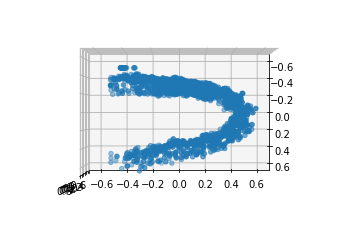

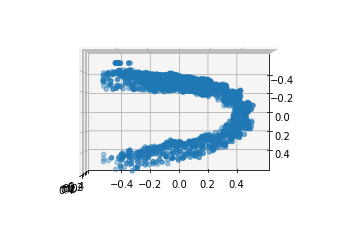

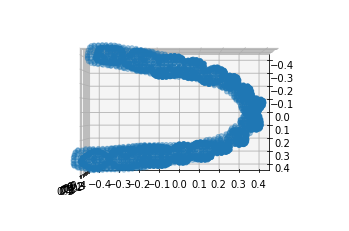

In [ ]:
plot(X_train[180]*Rx(0/fac),True)
plot(X_train[100]*Rx(0/fac),True)
plot(X_test[9]*Rx(0/fac),True)

(0.0, 1.0)

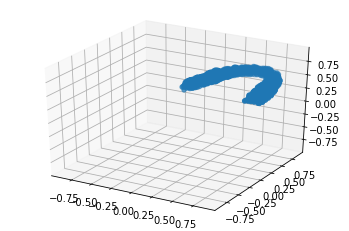

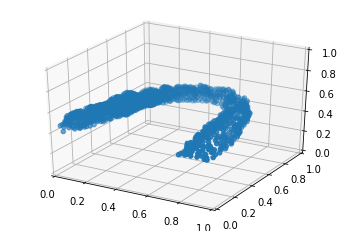

In [ ]:
points=X_train
points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
plot(points_normalized[0])
input=points_normalized[0]
  #inputt = points[0,:,:]
  #inputt = inputt.permute([1,0]).detach().cpu().numpy()
fig = plt.figure()
ax_x = fig.add_subplot(111, projection='3d')
x_ = input
ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2])
ax_x.set_xlim([0,1])
ax_x.set_ylim([0,1])
ax_x.set_zlim([0,1])

In [ ]:
BATCH_SIZE = batch_size
use_cuda = torch.cuda.is_available()
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.cuda() if use_cuda else alpha

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    if use_cuda:
        interpolates = interpolates.cuda()
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates, _ = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda() if use_cuda else torch.ones(
                                  disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty



class PointcloudDatasetAE(Dataset):
    def __init__(self, root, list_point_clouds):
        self.root = root
        self.list_files = list_point_clouds
        
    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        points = PyntCloud.from_file(self.list_files[index])
        points.points=points.points[0:num_points]
        cx=points.centroid[0]
        cy=points.centroid[1]
        cz=points.centroid[2]
        points = np.array(points.points)
        points=points[:,[0,1,2]]
        points=MoveScale3D(points,-cx,-cy,-cz,1)
        points=points/(2*np.max(points))
        points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
        points = points_normalized.astype(np.float)
        points = torch.from_numpy(points)
        
        return points

DATA_DIR=''
train_dataset = PointcloudDatasetNoisy(DATA_DIR, X_train)
train_dataloader = DataLoader(train_dataset, num_workers=2, shuffle=False, batch_size=batch_size)

test_dataset = PointcloudDatasetNoisy(DATA_DIR, X_test)
test_dataloader = DataLoader(test_dataset, num_workers=2, shuffle=False, batch_size=1)

for i,data in enumerate(train_dataloader):
  print(i)
  if i==0:
    x= data.float().to(device)
    print(x.shape)
  if i==1:
    y = data.float().to(device)
    loss_chamf,_=chamfer_distance(x,y)
    print(loss_chamf)
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0
torch.Size([310, 2048, 3])
1
tensor(0.0130, device='cuda:0')


In [ ]:
autoencoder = AutoEncoder(num_points).to(device)
generator = GenSAGAN(z_dim=z_dim).to(device)
discriminator = DiscSAGAN().to(device) 

In [ ]:
ext='Orginal+Mirrored-1240-[[128 128 256 128]]-[[ 128  128  128  256 6144]]-40-0.8-0.0005-2048-30'
typeFile='Best_Val'
filename='/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanAE/'+ext+'/models/'+typeFile+'_ae_.pth.tar'
autoencoder= load_checkpoint(autoencoder,filename=filename)

=> loading checkpoint '/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanAE/Orginal+Mirrored-1240-[[128 128 256 128]]-[[ 128  128  128  256 6144]]-40-0.8-0.0005-2048-30/models/Best_Val_ae_.pth.tar'
=> loaded checkpoint '/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanAE/Orginal+Mirrored-1240-[[128 128 256 128]]-[[ 128  128  128  256 6144]]-40-0.8-0.0005-2048-30/models/Best_Val_ae_.pth.tar' (epoch 2674)


# Summary Writer and Training Code

In [ ]:
ROOT_DIR = './MoldScanGAN/New-Z'+  str(len(X_train))+'-'+str(momentum)+'z'+str(z_dim)+'-'+str(batch_size)+'-'+str(g_lr)+'-'+str(im_size)+'-'+str(np.array([sag1,sag2,sad1,sad2]))+'-'+str(num_points)+'-'+str(LAMBDA)

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR )

LOG_DIR = ROOT_DIR+ '/logs/'
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

OUTPUTS_DIR = ROOT_DIR+ '/outputs/'
if not os.path.exists(OUTPUTS_DIR):
    os.makedirs(OUTPUTS_DIR)

MODEL_DIR = ROOT_DIR+ '/models/'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

summary_writer = SummaryWriter(LOG_DIR)

In [ ]:
ROOT_DIR

'./MoldScanGAN/New-Z1240-0.8z32-310-0.0005-32-[ 64  64 256 256]-2048-10'

### Generate random sample

In [ ]:
def test_model(generator, autoencoder,epoch,n=2):
    for i in tqdm(range(n)):
        # points = PyntCloud.from_file(X_test[i])
        # points = np.array(points.points)
        # points_normalized = (points - (-0.5)) / (0.5 - (-0.5))
        # points = points_normalized.astype(np.float)
        # points = torch.from_numpy(points).unsqueeze(0)
        # points = points.permute([0,2,1]).float().to(device)
        # print(points.shape)

        autoencoder.eval()
        generator.eval()
        #z = torch.randn(1, z_dim).to(device)
        z = generaterand(a=1,z_dim=z_dim,Normal=False,mu=-1,std=1)
        with torch.no_grad():
                gen_out, _ = generator(z)
                out_data = autoencoder.decode(gen_out)
                # loss = chamfer_loss(out_data, points)
        # print(loss.item())
        out_data=out_data.permute([0,2,1])
        output = out_data[0,:,:]
        output = output.permute([1,0]).detach().cpu().numpy()

        # inputt = points[0,:,:]
        # inputt = inputt.permute([1,0]).detach().cpu().numpy()
        print(epoch)
        fig = plt.figure()
        ax_x = fig.add_subplot(111, projection='3d')
        ax_x.text2D(0.05, 0.95, str(epoch), transform=ax_x.transAxes)
        x_ = output
        ax_x.scatter(x_[:, 0], x_[:, 1], x_[:,2])
        ax_x.set_xlim([0,1])
        ax_x.set_ylim([0,1])
        ax_x.set_zlim([0,1])
        print(out_data.shape)   
        fig.savefig(OUTPUTS_DIR+'/{}_{}_{}.png'.format(epoch, i, 'out'))

### Optimizer Parameters

In [ ]:
g_optim = torch.optim.Adam(generator.parameters(), lr=g_lr,betas=(momentum, 0.999))
d_optim = torch.optim.Adam(discriminator.parameters(), lr=d_lr,betas=(momentum, 0.999))

In [ ]:
print('Training')
gcost_list=[]
dcost_list=[]
chamf_list=[]
min=100000000
for epoch in range(n_epochs):
    autoencoder.eval()
    generator.train()
    discriminator.train()
    g_cost=0
    d_cost=0
    chamf_cost=0
    for i, data in enumerate(train_dataloader):
        data = data.float().to(device)
        with torch.no_grad():
            gfv = autoencoder.encode(data)
        z = torch.randn(data.shape[0], z_dim).to(device)
        #z = generaterand(a=data.shape[0],z_dim=z_dim,Normal=False,mu=-1,std=1)

        g_optim.zero_grad()
        d_optim.zero_grad()

        fake_out, _ = generator(z)

        d_fake, _ = discriminator(fake_out)
        d_real, _ = discriminator(gfv)
        d_loss = -(torch.mean(d_real) - torch.mean(d_fake))
        d_grad_penalty = calc_gradient_penalty(discriminator, gfv, fake_out)
        total_d_loss = d_loss + d_grad_penalty
        total_d_loss.backward()
        d_optim.step()

        #####################################

        g_optim.zero_grad()
        d_optim.zero_grad()
        
        #Generator Loss
        g_out, _ = generator(z)
        
        d_fake, _ = discriminator(g_out)
        gen_loss = -torch.mean(d_fake)
        
        out_data = autoencoder.decode(g_out)
        loss_chamf,_ = chamfer_distance(out_data, data)
        

        loss = gen_loss
        loss.backward()
        g_optim.step()
        #uptdate parameters
        g_cost+=loss.item()
        d_cost+=total_d_loss.item()
        chamf_cost+=loss_chamf.item()

        print('Epoch: {}, Iteration: {},  G Loss: {:.4f} D Loss: {:.4f}, Ch Loss: {:.6f} '.format(epoch, i, gen_loss.item(), total_d_loss.item(),loss_chamf.item()))
        summary_writer.add_scalar('G Loss', loss.item())
        summary_writer.add_scalar('GP  Loss', d_grad_penalty.item())
        summary_writer.add_scalar('D Loss', d_loss.item())
        summary_writer.add_scalar('Total D Loss', total_d_loss.item())
    
    #acummulate cost 
    chamf_list.append(chamf_cost/(i+1))
    gcost_list.append(g_cost/(i+1)) 
    dcost_list.append(d_cost/(i+1))
    #Learning rate decay
    '''
    optimizer_AE.param_groups[0]['lr'] =lr * (1 / (1 + decay * epoch))
    g_optim.param_groups[0]['lr'] =g_lr * (1 / (1 + decay * epoch))
    d_optim.param_groups[0]['lr'] =d_lr * (1 / (1 + decay * epoch))
    '''
    #Save models
    '''if np.min(chamf_list)<min and epoch>50:
      min=np.min(chamf_list[50:])
      torch.save(generator.state_dict(), MODEL_DIR+'{}_gen_.pt'.format(epoch))
      torch.save(discriminator.state_dict(), MODEL_DIR+'{}_disc_.pt'.format(epoch))'''
    
    if epoch % 20 == 0:
      test_model(generator, autoencoder, epoch)
      torch.save(generator.state_dict(), MODEL_DIR+'{}_gen_.pt'.format(epoch))
      torch.save(discriminator.state_dict(), MODEL_DIR+'{}_disc_.pt'.format(epoch))
torch.save(generator.state_dict(), MODEL_DIR+'{}_gen_.pt'.format(epoch))
torch.save(discriminator.state_dict(), MODEL_DIR+'{}_disc_.pt'.format(epoch))

Output hidden; open in https://colab.research.google.com to view.

# Graphs

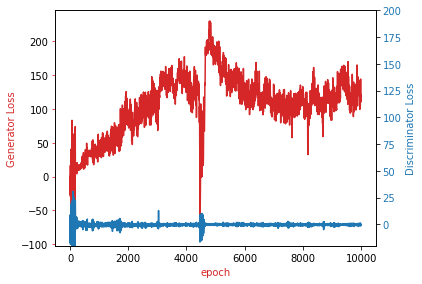

In [ ]:

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(gcost_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('Generator Loss',color=color)
ax1.tick_params(axis='y', color=color)
#ax1.set_ylim(0,100)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Discriminator Loss', color=color)  
ax2.plot( dcost_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
ax2.set_ylim(-20,200)
ROOT_DIR2 = OUTPUTS_DIR
figname=ROOT_DIR2+'AECosts-1-.png'
fig.savefig(figname)

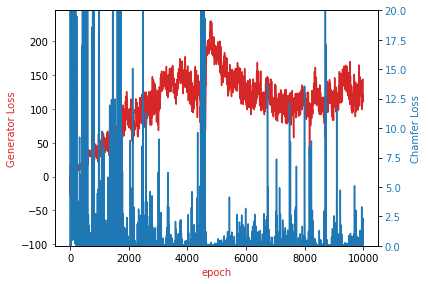

In [ ]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(gcost_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('Generator Loss',color=color)
ax1.tick_params(axis='y', color=color)
#ax1.set_ylim(0,100)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Chamfer Loss', color=color)  
ax2.plot( chamf_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
ax2.set_ylim(0,20)
ROOT_DIR2 = OUTPUTS_DIR
figname=ROOT_DIR2+'AECosts-2-.png'
fig.savefig(figname)

In [ ]:
print(np.argmin(chamf_list),np.argmin(gcost_list))

8901 4467


In [ ]:
print(chamf_list[np.argmin(chamf_list)],chamf_list[np.argmin(gcost_list)])

0.007559651508927345 29.291178703308105


In [ ]:
min=100000000
idx=0
for i in range(len(chamf_list)):
  if i%20==0:
    if chamf_list[i]<min:
      min=chamf_list[i]
      idx=i

In [ ]:
idx

9880

In [ ]:
chamf_list[idx]

0.007661327836103737

# Fake Data



In [ ]:
num_gen=9880
size_fake=4000
name='New-Z1240-0.8z32-310-0.0005-32-[ 64  64 256 256]-2048-10'
weights_gen = '/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanGAN/'+name+'/models/'+str(num_gen)+'_gen_.pt'
weight_disc = '/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanGAN/'+name+'/models/'+str(num_gen)+'_disc_.pt'

In [ ]:
pointsAE = np.load('./PC_Arrays/pointsAE3-2-2048.npy',allow_pickle=True)
pointsAE= (pointsAE + (-0.5)) / (0.5 - (-0.5))
aligned_Tensor = PointcloudDatasetNoisy('DATA_DIR', pointsAE)
aligned_dataloader = DataLoader(aligned_Tensor, num_workers=0, shuffle=True, batch_size=1)

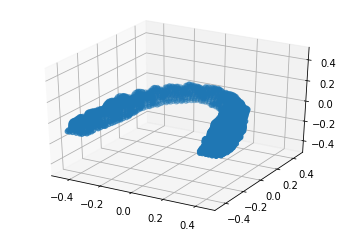

In [ ]:
plot(pointsAE[0])

In [ ]:
pointsAE.shape

(273, 2048, 3)

In [ ]:
autoencoder = AutoEncoder(num_points).to(device)
ext='Orginal+Mirrored-1240-[[128 128 256 128]]-[[ 128  128  128  256 6144]]-40-0.8-0.0005-2048-30'
typeFile='Best_Val'
filename='/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanAE/'+ext+'/models/'+typeFile+'_ae_.pth.tar'
autoencoder= load_checkpoint(autoencoder,filename=filename)

generator = GenSAGAN(z_dim=z_dim).to(device)
generator.load_state_dict(torch.load(weights_gen))

discriminator = DiscSAGAN().to(device)
discriminator.load_state_dict(torch.load(weight_disc))

autoencoder.eval()
generator.eval()
discriminator.eval()

=> loading checkpoint '/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanAE/Orginal+Mirrored-1240-[[128 128 256 128]]-[[ 128  128  128  256 6144]]-40-0.8-0.0005-2048-30/models/Best_Val_ae_.pth.tar'
=> loaded checkpoint '/content/gdrive/MyDrive/JMSE2022/MoldScan/MoldScanAE/Orginal+Mirrored-1240-[[128 128 256 128]]-[[ 128  128  128  256 6144]]-40-0.8-0.0005-2048-30/models/Best_Val_ae_.pth.tar' (epoch 2674)


DiscSAGAN(
  (layer1): SpectralNorm(
    (module): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  )
  (layer2): SpectralNorm(
    (module): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  )
  (layer3): SpectralNorm(
    (module): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  )
  (layer4): SpectralNorm(
    (module): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
  )
  (attn1): SAttn(
    (query): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (key): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (value): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (conv1d): ConvTranspose1d(128, 144, kernel_size=(1,), stride=(1,))
)

# Generate

In [ ]:
'''PCs = np.load('./PC_Arrays/PCs(RL-GAN).npy',allow_pickle=True)'''
PCs=[]
chamf_list2=test_model2(generator, autoencoder, 1,n=100,plotmod=True,PCs=PCs)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
chamf_list2

array([0.0056911 , 0.00666965, 0.00453671, 0.00479449, 0.00629684,
       0.00620263, 0.00730222, 0.00661876, 0.0063409 , 0.00644656,
       0.0055077 , 0.00743098, 0.00697989, 0.00662461, 0.00623189,
       0.00522909, 0.00543138, 0.00602011, 0.00552375, 0.0056462 ,
       0.01079009, 0.0047261 , 0.00660667, 0.0102524 , 0.0061193 ,
       0.00741995, 0.00602891, 0.00502994, 0.00456423, 0.00654743,
       0.00542268, 0.00672446, 0.00602528, 0.00598228, 0.00540996,
       0.0059825 , 0.00558376, 0.01146597, 0.00538414, 0.0051841 ,
       0.00601032, 0.0069352 , 0.00535286, 0.00696692, 0.00641705,
       0.00666353, 0.00522934, 0.0065273 , 0.0057998 , 0.00620735,
       0.00560809, 0.00518928, 0.00556226, 0.00439028, 0.00586314,
       0.00537336, 0.00691401, 0.00542125, 0.00740507, 0.006431  ,
       0.0048637 , 0.00464911, 0.00591831, 0.00883772, 0.00553483,
       0.00642878, 0.0055322 , 0.00728609, 0.00633776, 0.00699193,
       0.00600586, 0.01063194, 0.00928108, 0.0064333 , 0.00737

Text(0.5, 1.0, 'Histogram (GAN2 PC)')

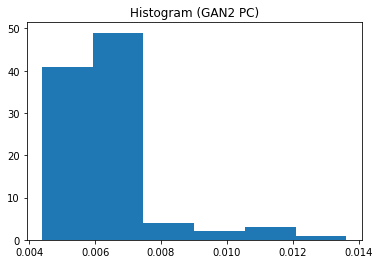

In [ ]:
 #Sturge’s Rule
bn=int(np.round(1+3.322*np.log10(30)))
#_ = plt.hist(chamf_list, bins=np.array(8))
_ = plt.hist(chamf_list2, bins=bn)
plt.title("Histogram (GAN2 PC)")

In [ ]:
print(np.mean(chamf_list2),np.std(chamf_list2))

0.006385195 0.0014598601


# Filters

In [ ]:
it=0
if it==0:
  zf2=[]

In [ ]:
len(zf2)

0

In [ ]:
PCs,zf=genPCs(generator, autoencoder,1000,it=it,zf=zf2)

In [ ]:
#PCs = np.load('./PC_Arrays/It-'+str(it)+'-PCs-1000.npy',allow_pickle=True)
#zf=np.load('./PC_Arrays/It-'+str(it)+'-Zs-1000.npy',allow_pickle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 1000/1000 [00:01<00:00, 534.27it/s]


Removed Points: 0 .Remaining Points: 1000
Average: 0.00021086466 Std 3.6714832e-06


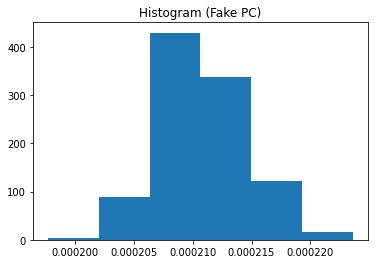

In [ ]:
remove=Filter1(PCs)

In [ ]:
PCs2,zf2=RemovePCs(remove=remove,PCs=PCs,z=zf)

In [ ]:
np.save('PC_Arrays/It-'+str(it)+str(X_train.shape)+'-PCs2.npy', PCs2)
np.save('PC_Arrays/It-'+str(it)+str(X_train.shape)+'-Zf2.npy', zf2)
len(zf2)

1000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 1000/1000 [00:01<00:00, 528.30it/s]


Removed Points: 0 .Remaining Points: 1000
Average: 0.00024029032 Std 1.9151326e-05


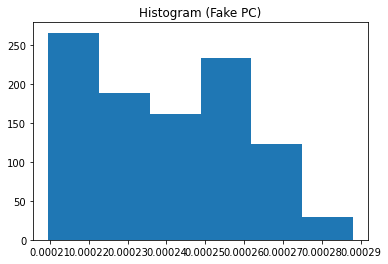

In [ ]:
_=Filter1(PCs2)

In [ ]:
chamf_list=chamf_Mat(it=it,PCs=PCs2)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 1000/1000 [28:43<00:00,  1.72s/it]


In [ ]:
#it=it
#chamf_list=np.load('./PC_Arrays/Pairs-it-'+str(it)+'.npy',allow_pickle=True)

In [ ]:
remove=Filter2(chamf_list)

In [ ]:
print(len(remove))

995


In [ ]:
remove2=Filter22(chamf_list)

In [ ]:
print(len(remove2))

995


In [ ]:
PCs3,zf3=RemovePCs(remove=remove,PCs=PCs2,z=zf2)
len(PCs3)
np.save('PC_Arrays/It-'+str(it)+str(X_train.shape)+'-PCs3.npy', PCs3)
np.save('PC_Arrays/It-'+str(it)+str(X_train.shape)+'-Zf3.npy', zf3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 122/122 [00:00<00:00, 514.93it/s]


Removed Points: 0 .Remaining Points: 122
Average: 0.00036031325 Std 3.9884922e-05


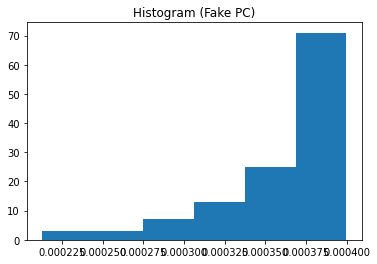

In [ ]:
_=Filter1(PCs3)

In [ ]:
PCs3=np.array(PCs3)
PCs32=(PCs3 + (-0.5)) / (0.5 - (-0.5))
for i in range(len(PCs32)):
  plot(PCs32[i])

In [ ]:
#FakePcs=[]

In [ ]:
#FakePCs=np.load('./PC_Arrays/All_Fake_PCs'+str(X_train.shape)+'.npy',allow_pickle=True)
FakePCs=[]
FakePCs2=[]
for i in tqdm(range(len(FakePCs))):
  FakePCs2.append(FakePCs[i])
for i in tqdm(range(len(PCs3))):
  FakePCs2.append(PCs3[i])
FakePCs2=np.array(FakePCs2)
np.save('PC_Arrays/All_Fake_PCs'+str(X_train.shape)+'.npy', FakePCs2)

0it [00:00, ?it/s]
100%|██████████| 122/122 [00:00<00:00, 475120.79it/s]


In [ ]:
len(PCs2)

734

In [ ]:
f1=[]
#f1=np.load('./PC_Arrays/F1-Shapes'+str(X_train.shape)+'.npy',allow_pickle=True)
f2=[]
#f2=np.load('./PC_Arrays/F2-Shapes'+str(X_train.shape)+'.npy',allow_pickle=True)
f1.append(len(PCs2))
f2.append(len(PCs3))
print(f1)
print(f2)
np.save('PC_Arrays/F1-Shapes'+str(X_train.shape)+'.npy', f1)
np.save('PC_Arrays/F2-Shapes'+str(X_train.shape)+'.npy', f2)

[734]
[122]


In [ ]:
FakePCs=np.load('./PC_Arrays/All_Fake_PCs'+str(X_train.shape)+'.npy',allow_pickle=True)
FakePCs.shape

(122, 2048, 3)

# Final Filter

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 122/122 [00:00<00:00, 510.47it/s]


Removed Points: 0 .Remaining Points: 122
Average: 0.00036031325 Std 3.9884922e-05


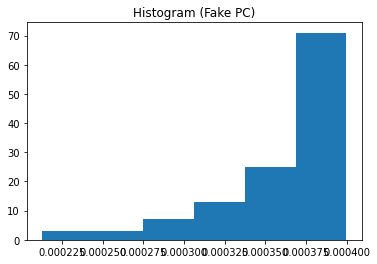

In [ ]:
_=Filter1(FakePCs)

In [ ]:
chamf_list=chamf_Mat(it=it,PCs=FakePCs)

  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 122/122 [00:25<00:00,  4.69it/s]


In [ ]:
remove=Filter22(chamf_list)

In [ ]:
AllPCs,_=RemovePCs(remove=remove,PCs=FakePCs,z=zf2)
len(AllPCs)
np.save('PC_Arrays/All-Its'+str(X_train.shape)+'.npy', AllPCs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 122/122 [00:00<00:00, 528.40it/s]


Removed Points: 0 .Remaining Points: 122
Average: 0.00036031325 Std 3.9884922e-05


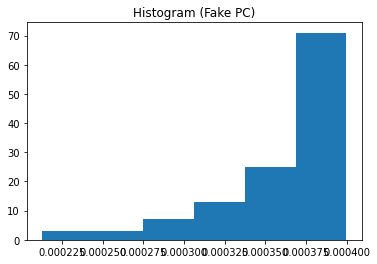

In [ ]:
_=Filter1(AllPCs)

In [ ]:
a = np.load('./PC_Arrays/GAN-1-'+str(X_train.shape)+'.npy',allow_pickle=True)
#a= (a - (-0.5)) / (0.5 - (-0.5))

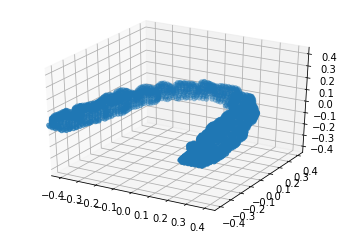

In [ ]:
plot(a[0][0])

In [ ]:
AllPCs=(np.array(AllPCs) + (-0.5)) / (0.5 - (-0.5))

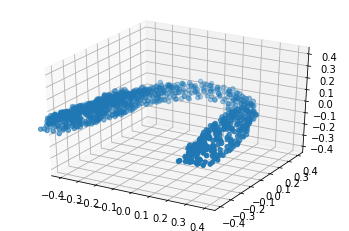

In [ ]:
plot(AllPCs[2])

In [ ]:
AE2=[]
#Testing
for i in tqdm(range(len(a[1]))):
  AE2.append(a[1][i])
#Training 
for i in tqdm(range(len(a[0]))):
  AE2.append(a[0][i])
#GAN
for i in tqdm(range(len(AllPCs))):
  AE2.append(AllPCs[i])


100%|██████████| 122/122 [00:00<00:00, 150060.14it/s]


In [ ]:
AE2=np.array(AE2)

In [ ]:
AE2.shape

(327, 2048, 3)

In [ ]:
np.save('PC_Arrays/Points-AE2'+str(X_train.shape)+'.npy', AE2)

In [ ]:
a = np.load('./PC_Arrays/Points-AE2'+str(X_train.shape)+'.npy',allow_pickle=True)

In [ ]:
a.shape

(327, 2048, 3)

# Histogram

In [ ]:
pointsAE = np.load('./PC_Arrays/All_Mod-Z-PCs-0-374.npy',allow_pickle=True)
aligned_Tensor = PointcloudDatasetNoisy('DATA_DIR', pointsAE)
aligned_dataloader = DataLoader(aligned_Tensor, num_workers=0, shuffle=True, batch_size=1)

In [ ]:
pointsAE.shape

(228, 2048, 3)

In [ ]:
chamf_list=[]
zeros=[]
x=aligned_dataloader.dataset[0].float().to(device)
x= x.unsqueeze(0)
for j in range(30):
    y=aligned_dataloader.dataset[j].float().to(device)
    y= y.unsqueeze(0)
    loss_chamf,_=chamfer_distance(x,y)
    chamf_list.append(loss_chamf.detach().cpu().numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
#Sturge’s Rule
bn=int(np.round(1+3.322*np.log10(30)))

Text(0.5, 1.0, 'Histogram (Original PC)')

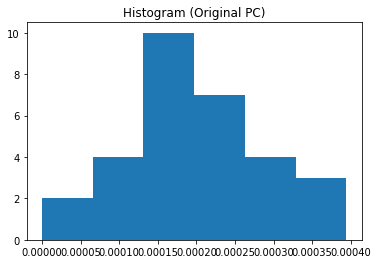

In [ ]:
#Sturge’s Rule
bn=int(np.round(1+3.322*np.log10(30)))
#_ = plt.hist(chamf_list, bins=np.array(8))
_ = plt.hist(chamf_list, bins=bn)
plt.title("Histogram (Original PC)")

In [ ]:
bin,limits=np.histogram(chamf_list, bins=bn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Text(0.5, 1.0, 'Histogram (Generated PC)')

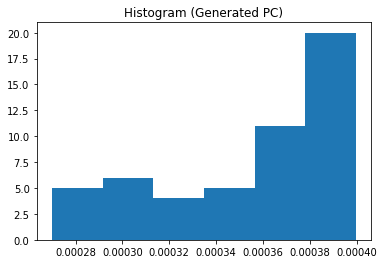

In [ ]:
chamf_list2=[]
for i in range(1):
  x=aligned_dataloader.dataset[0].float().to(device)
  x= x.unsqueeze(0)
  for j in range(177,len(pointsAE)):
    y=aligned_dataloader.dataset[j].float().to(device)
    y= y.unsqueeze(0)
    loss_chamf,_=chamfer_distance(x,y)
    chamf_list2.append(loss_chamf.detach().cpu().numpy())
_ = plt.hist(chamf_list2, bins=bn)
plt.title("Histogram (Generated PC)")

In [ ]:
print(np.mean(chamf_list2),np.std(chamf_list2))
print(np.mean(chamf_list),np.std(chamf_list))


0.0003548052 3.9213865e-05
0.0002044921 8.699671e-05


In [ ]:
bin2,limits2=np.histogram(chamf_list2, bins=bn)
limits2

array([0.00027189, 0.0002927 , 0.00031352, 0.00033433, 0.00035515,
       0.00037596, 0.00039678], dtype=float32)

In [ ]:
pointsAE3=[]
for i in range(len(pointsAE)):
  if  i <177:
    pointsAE3.append(pointsAE[i])
  else:
    if  i in keep:
      pointsAE3.append(pointsAE[i])
pointsAE3=np.array(pointsAE3)
np.save('PC_Arrays/pointsAE3-Final-'+str(pointsAE.shape[1])+'.npy', pointsAE3)

In [ ]:
pointsAE3.shape
aligned_Tensor = PointcloudDatasetNoisy("DATA_DIR", pointsAE3)
aligned_dataloader = DataLoader(aligned_Tensor, num_workers=0, shuffle=True, batch_size=1)
len(aligned_dataloader)
chamf_list=[]
zeros=[]
for i in range(1):
  x=aligned_dataloader.dataset[0].float().to(device)
  x= x.unsqueeze(0)
  for j in range(len(pointsAE3)):
    y=aligned_dataloader.dataset[j].float().to(device)
    y= y.unsqueeze(0)
    loss_chamf,_=chamfer_distance(x,y)
    chamf_list.append(loss_chamf.detach().cpu().numpy())
_ = plt.hist(chamf_list, bins=np.array(8))
plt.title("Histogram (Generated PC- Final)")

# Controlled Z

In [ ]:
zf = np.load('./PC_Arrays/Mod-Z2-Zs-2-150000.npy',allow_pickle=True)

In [ ]:
cov=np.cov(np.transpose(zf))
mu=np.mean(zf)
mean=mu*np.ones(32)

In [ ]:
cov.shape

(32, 32)

In [ ]:
cov

array([[ 1.26057046,  1.07645726, -0.76520974, ...,  0.90813534,
        -0.10225238,  0.35992192],
       [ 1.07645726,  1.42366196, -0.75290785, ...,  1.22537782,
        -0.83048555,  0.70457589],
       [-0.76520974, -0.75290785,  1.63760737, ...,  0.25753585,
        -0.51216788, -0.24086892],
       ...,
       [ 0.90813534,  1.22537782,  0.25753585, ...,  3.26009206,
        -1.34622487,  0.03018006],
       [-0.10225238, -0.83048555, -0.51216788, ..., -1.34622487,
         2.04976086, -0.56264158],
       [ 0.35992192,  0.70457589, -0.24086892, ...,  0.03018006,
        -0.56264158,  0.79112513]])

In [ ]:
#np.save('PC_Arrays/COV-'+str(out_data.shape[0])+'.npy', cov)

In [ ]:
mu

-0.05297160583087381

In [ ]:
z_controlled= np.random.multivariate_normal(mean, cov,150000)
z_controlled.shape
zf=torch.from_numpy(z_controlled).to(device)
zf=zf.type(torch.cuda.FloatTensor)

In [ ]:
with torch.no_grad():
  gen_out, _ = generator(zf)
  out_data = autoencoder.decode(gen_out)
  out_data = out_data.detach().cpu().numpy()
out_data.shape[0]
np.save('PC_Arrays/Corr-Fake-2-PCs-'+str(out_data.shape[0])+'.npy', out_data)
np.save('PC_Arrays/Corr-Fake-2-Zs-'+str(out_data.shape[0])+'.npy', z_controlled)

# New random vector


In [ ]:
z=generaterand(a=150000,Normal=False)

In [ ]:
z.shape

In [ ]:
zf=generaterand(a=150000,Normal=False)
with torch.no_grad():
  gen_out, _ = generator(zf)
  out_data = autoencoder.decode(gen_out)
  out_data = out_data.detach().cpu().numpy()
out_data.shape[0]
#np.save('PC_Arrays/Corr-Fake-PCs-'+str(out_data.shape[0])+'.npy', out_data)

In [ ]:
out_data.shape

In [ ]:
PCs = np.load('./PC_Arrays/Corr-PCs-150000.npy',allow_pickle=True)
z= np.load('./PC_Arrays/Fake-Z-Final-150000.npy',allow_pickle=True)

# MOD COV

In [ ]:
cov = np.load('./PC_Arrays/COV-150000.npy',allow_pickle=True)

In [ ]:
zf = np.load('./PC_Arrays/Mod-Z-Zs-5-150000.npy',allow_pickle=True)

In [ ]:
cov=np.cov(np.transpose(zf))
mu=np.mean(zf)
mean=mu*np.ones(32)

In [ ]:
n=10
noise=-1.01
idx=np.random.randint(0,31,n)
modmat=np.eye(32)
for i in range(len(idx)):
  modmat[idx[i]][idx[i]]=noise
modmat

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
z_controlled= np.random.multivariate_normal(mean, cov,150000)
z_controlled=z_controlled@modmat
z_controlled.shape

(150000, 32)

In [ ]:
zf=torch.from_numpy(z_controlled).to(device)
zf=zf.type(torch.cuda.FloatTensor)

In [ ]:
with torch.no_grad():
  gen_out, _ = generator(zf)
  out_data = autoencoder.decode(gen_out)
  out_data = out_data.detach().cpu().numpy()
out_data.shape[0]
np.save('PC_Arrays/Corr-COV-2-PCs-'+str(out_data.shape[0])+'.npy', out_data)
np.save('PC_Arrays/Corr-COV-2-Zs-'+str(out_data.shape[0])+'.npy', z_controlled)

In [ ]:
a=np.random.normal(0,1,[3,3])

In [ ]:
a

array([[-1.92398967, -0.33329354,  0.3246445 ],
       [-0.35284547, -0.50989744, -0.20721347],
       [ 0.67339137,  0.4192734 , -1.7059418 ]])

In [ ]:
modmat=np.eye(3)

In [ ]:
modmat[2][2]=-1

In [ ]:
modmat

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0., -1.]])

In [ ]:
a@modmat

array([[-1.92398967, -0.33329354, -0.3246445 ],
       [-0.35284547, -0.50989744,  0.20721347],
       [ 0.67339137,  0.4192734 ,  1.7059418 ]])

# Merge all PC

In [ ]:
name='./PC_Arrays/Mod-Z-PCs-1-150000.npy'
PCs = np.load(final_name,allow_pickle=True)

In [ ]:
All_PCs=[]
for i in range(177,len(PCs)):
  All_PCs.append(PCs[i])

In [ ]:
len(All_PCs)

18

In [ ]:
i=9
final_name=name[0:22]+str(i+1)+name[23:]

In [ ]:
final_name

'./PC_Arrays/Mod-Z-PCs-10-150000.npy'

In [ ]:
name='./PC_Arrays/Mod-Z-PCs-1-150000.npy'
All_PCs=[]
for j in range(0,11):
  final_name=name[0:22]+str(j+1)+name[23:]
  PCs = np.load(final_name,allow_pickle=True)
  print(len(PCs)-177)
  for i in range(177,len(PCs)):
    All_PCs.append(PCs[i])
out_data=np.array(All_PCs)


18
32
24
39
48
49
22
46
29
41
26


In [ ]:
out_data.shape

(374, 2048, 3)

# Test GAN

In [ ]:
pointsAE = np.load('./PC_Arrays/finalpoints22048.npy',allow_pickle=True)
#pointsAE= (pointsAE - (-0.5)) / (0.5 - (-0.5))
aligned_Tensor = PointcloudDatasetNoisy('DATA_DIR', pointsAE)
aligned_dataloader = DataLoader(aligned_Tensor, num_workers=0, shuffle=True, batch_size=1)

In [ ]:
pointsAE.shape

(240, 2048, 3)

In [ ]:
num_gen=7320
size_fake=4000
name='New-Z252-0.8z32-42-0.0005-32-[ 64  64 256 256]-2048-10'
weights_gen = '/content/gdrive/MyDrive/MSEC2022/MoldScan/MoldScanGAN/'+name+'/models/'+str(num_gen)+'_gen_.pt'
weight_disc = '/content/gdrive/MyDrive/MSEC2022/MoldScan/MoldScanGAN/'+name+'/models/'+str(num_gen)+'_disc_.pt'


generator = GenSAGAN(z_dim=z_dim).to(device)
generator.load_state_dict(torch.load(weights_gen))

discriminator = DiscSAGAN().to(device)
discriminator.load_state_dict(torch.load(weight_disc))
#ddpg.load_state_dict(torch.load(weight_ddpg))

autoencoder.eval()
#autoencoder1.eval()
generator.eval()
discriminator.eval()

DiscSAGAN(
  (layer1): SpectralNorm(
    (module): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  )
  (layer2): SpectralNorm(
    (module): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  )
  (layer3): SpectralNorm(
    (module): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  )
  (layer4): SpectralNorm(
    (module): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
  )
  (attn1): SAttn(
    (query): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (key): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (value): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (conv1d): ConvTranspose1d(128, 144, kernel_size=(1,), stride=(1,))
)

In [ ]:
def genPCs(generator, autoencoder,number_PCs=10000,z_dim=z_dim,it=0,zf=0):
  if it==0:
    zf = torch.randn(number_PCs, z_dim).to(device)
  else:
    cov=np.cov(np.transpose(zf))
    mu=np.mean(zf)
    mean=mu*np.ones(32)
    print(mu)
    z_controlled= np.random.multivariate_normal(mean, cov,number_PCs)
    z_controlled.shape
    zf=torch.from_numpy(z_controlled).to(device)
    zf=zf.type(torch.cuda.FloatTensor)
  with torch.no_grad():
    gen_out, _ = generator(zf)
    out_data = autoencoder.decode(gen_out)
    out_data = out_data.detach().cpu().numpy()
  return out_data,zf.detach().cpu().numpy()

def Filter0(PCs):
  pointsAE = np.load('./PC_Arrays/finalpoints22048.npy',allow_pickle=True)
  pointsAE= (pointsAE - (-0.5)) / (0.5 - (-0.5))
  aligned_Tensor = PointcloudDatasetNoisy('DATA_DIR', pointsAE)
  aligned_dataloader = DataLoader(aligned_Tensor, num_workers=0, shuffle=True, batch_size=1)
  aligned_Tensor2 = PointcloudDatasetNoisy(DATA_DIR, PCs)
  aligned_dataloader2 = DataLoader(aligned_Tensor2, num_workers=0, shuffle=True, batch_size=1)
  min= 5.1408e-05
  max=0.0004
  x=aligned_dataloader.dataset[1].float().to(device)
  x= x.unsqueeze(0)
  final_points=PCs
  chamf_list_Org=[]
  size=len(PCs)
  remove=[]
  start=0
  for i in range(1):
    for j in (range(0,size)):
        if not j in remove:
          y=aligned_dataloader2.dataset[j].float().to(device)
          y= y.unsqueeze(0)
          loss_chamf,_=chamfer_distance(x,y)
          chamf_list_Org.append(loss_chamf.detach().cpu().numpy())
  return np.mean(chamf_list_Org),np.std(chamf_list_Org)

def RemovePCs(remove=[],PCs=[],z=[]):
  pointsAE2=[]
  zf=[]
  for i in range(len(PCs)):
    if  not i in remove:
      pointsAE2.append(PCs[i])
      zf.append(z[i])
  return pointsAE2,zf
  

In [ ]:
def Filter1(PCs):
  pointsAE = np.load('./PC_Arrays/finalpoints22048.npy',allow_pickle=True)
  pointsAE= (pointsAE - (-0.5)) / (0.5 - (-0.5))
  aligned_Tensor = PointcloudDatasetNoisy('DATA_DIR', pointsAE)
  aligned_dataloader = DataLoader(aligned_Tensor, num_workers=0, shuffle=True, batch_size=1)
  aligned_Tensor2 = PointcloudDatasetNoisy(DATA_DIR, PCs)
  aligned_dataloader2 = DataLoader(aligned_Tensor2, num_workers=0, shuffle=True, batch_size=1)
  min= 5.1408e-05
  max=0.0004
  x=aligned_dataloader.dataset[1].float().to(device)
  x= x.unsqueeze(0)
  final_points=PCs
  chamf_list_Org=[]
  size=len(PCs)
  remove=[]
  start=0
  for i in range(1):
    for j in (range(0,size)):
        if not j in remove:
          y=aligned_dataloader2.dataset[j].float().to(device)
          y= y.unsqueeze(0)
          loss_chamf,_=chamfer_distance(x,y)
          chamf_list_Org.append(loss_chamf.detach().cpu().numpy())
          if loss_chamf<min:
            remove.append(j)
          if loss_chamf>max:
            remove.append(j)
      
  return remove

In [ ]:
name=name
k=0
start=4000
final=10000
stats=np.zeros((int((final-start)/20),3))
for i in tqdm(range(start,final)):
  if i%20==0:
    #print(i)
    num_gen=i
    weights_gen = '/content/gdrive/MyDrive/MSEC2022/MoldScan/MoldScanGAN/'+name+'/models/'+str(num_gen)+'_gen_.pt'
    weight_disc = '/content/gdrive/MyDrive/MSEC2022/MoldScan/MoldScanGAN/'+name+'/models/'+str(num_gen)+'_disc_.pt'
    generator = GenSAGAN(z_dim=z_dim).to(device)
    generator.load_state_dict(torch.load(weights_gen))

    discriminator = DiscSAGAN().to(device)
    discriminator.load_state_dict(torch.load(weight_disc))
#ddpg.load_state_dict(torch.load(weight_ddpg))

    autoencoder.eval()
#autoencoder1.eval()
    generator.eval()
    discriminator.eval()
    PCs,zf=genPCs(generator, autoencoder,200,it=0,zf=[])
    remove=Filter1(PCs)
    PCs,zf=RemovePCs(remove=remove,PCs=PCs,z=zf)
    if len(PCs)!=0:
      mu,stdpc=Filter0(PCs)
      stats[k][0]=int(start+k*20)
      stats[k][1]=mu
      stats[k][2]=stdpc
    k=k+1

  0%|          | 0/6000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 6000/6000 [03:34<00:00, 27.95it/s]


In [ ]:
len(PCs)

191

In [ ]:
len(remove)

9

In [ ]:
import pandas as pd

df = pd.DataFrame (stats)

name=ROOT_DIR+'GAN2.xlsx'

df.to_excel(name, index=False)

In [ ]:
ROOT_DIR

'./MoldScanGAN/New-Z252-0.8z32-42-0.0005-32-[ 64  64 256 256]-2048-10'